In [104]:
%load_ext autoreload
%autoreload 2

import sys         
sys.path.append('./../../src/') 
from data.load_data import load_ptbxl_data
from pathlib import Path
from signals.ecg import ECGSignal
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from signals.utils import parse_nested_feats
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

TARGET = 'diagnostic_class'
DATASET_PATH = Path("./../../data/ptbxl")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
ptbxl_data = load_ptbxl_data(
    sampling_rate=100,
    path = DATASET_PATH,
    target = TARGET
)

In [170]:
from joblib import Parallel, delayed

In [177]:
feats_list = []
n_samp = 12500


def get_feats_from_all_channels(channels, label):
    try:
        all_channels_feats = {}
        for i, data in enumerate(channels.T): 
            sig = ECGSignal("ecg", data, 100)
            secg = sig.aggregate()
            feats = sig.extract_features(plot=False)
            feats = parse_nested_feats(feats)
            all_channels_feats[i] = feats
        all_channels_feats = parse_nested_feats(all_channels_feats)
        all_channels_feats['label'] = label
        return all_channels_feats
    except Exception:
        pass

        
data_labels = zip(ptbxl_data['train']['X'][:n_samp, :, :], ptbxl_data['train']['y'][:n_samp])
feats_list = Parallel(n_jobs=-1)(
    delayed(get_feats_from_all_channels)(channels, label) for channels, label in tqdm(data_labels, total=n_samp)
)    

  0%|          | 0/12500 [00:00<?, ?it/s]

In [186]:
n_samp = len(ptbxl_data['val']['y'])
val_data_labels = zip(ptbxl_data['val']['X'][:n_samp, :, :], ptbxl_data['val']['y'][:n_samp])
val_feats_list = Parallel(n_jobs=-1)(
    delayed(get_feats_from_all_channels)(channels, label) for channels, label in tqdm(val_data_labels, total=n_samp)
)
val_feats_list = [f for f in val_feats_list if f is not None]
val_df = pd.DataFrame(val_feats_list)

  0%|          | 0/1642 [00:00<?, ?it/s]

In [187]:
n_samp = len(ptbxl_data['test']['y'])
test_data_labels = zip(ptbxl_data['test']['X'][:n_samp, :, :], ptbxl_data['test']['y'][:n_samp])
test_feats_list = Parallel(n_jobs=-1)(
    delayed(get_feats_from_all_channels)(channels, label) for channels, label in tqdm(test_data_labels, total=n_samp)
)
test_feats_list = [f for f in test_feats_list if f is not None]
test_df = pd.DataFrame(test_feats_list)

  0%|          | 0/1652 [00:00<?, ?it/s]

In [178]:
feats_list = [f for f in feats_list if f is not None]
df = pd.DataFrame(feats_list)

In [179]:
df

0__basic_features__mean  0__basic_features__std  \
0                     0.001508                0.109022   
1                    -0.002181                0.133428   
2                    -0.002770                0.121200   
3                    -0.003264                0.137803   
4                    -0.003769                0.082706   
...                        ...                     ...   
11649                -0.001353                0.123935   
11650                -0.004507                0.198666   
11651                -0.000110                0.091675   
11652                -0.000522                0.183093   
11653                 0.005792                0.450629   

       0__basic_features__median  0__basic_features__skewness  \
0                        -0.0090                     2.346514   
1                        -0.0430                     1.960769   
2                        -0.0370                     3.694111   
3                        -0.0265                     0.022307   
4                        -0.0230                     1.974023   
...                          ...                          ...   
11649                    -0.0310                     3.368628   
11650                    -0.0520                     3.918475   
11651                    -0.0240                     2.982955   
11652                    -0.0580                     3.543105   
11653                    -0.0370                     2.521847   

       0__basic_features__kurtosis  0__ecg_features__ibi_mean  \
0                        10.101222                   0.936667   
1                         4.740093                   1.271667   
2                        17.659544                   0.940000   
3                         3.891946                   0.806364   
4                         6.902985                   0.905000   
...                            ...                        ...   
11649                    15.011988                   0.765455   
11650                    16.812574                   0.958889   
11651                    12.417675                   1.081429   
11652                    14.171466                   1.054286   
11653                     7.164655                   0.975000   

       0__ecg_features__ibi_std  0__ecg_features__R_val  \
0                      0.013333                0.573000   
1                      0.075148                0.576857   
2                      0.018856                0.725800   
3                      0.037239                0.419667   
4                      0.050050                0.399000   
...                         ...                     ...   
11649                  0.015588                0.687667   
11650                  0.013699                1.086000   
11651                  0.027479                0.525250   
11652                  0.019166                1.021750   
11653                  0.281158                1.909444   

       0__agg_beat_features__p_loc  0__agg_beat_features__p_time  ...  \
0                                9                      0.057525  ...   
1                                6                      0.038350  ...   
2                                8                      0.051133  ...   
3                                8                      0.051133  ...   
4                                7                      0.044742  ...   
...                            ...                           ...  ...   
11649                            4                      0.025567  ...   
11650                            6                      0.038350  ...   
11651                            8                      0.051133  ...   
11652                            5                      0.031958  ...   
11653                            2                      0.012783  ...   

       11__agg_beat_features__r_loc  11__agg_beat_features__r_time  \
0                                20                       0.127833   
1                     

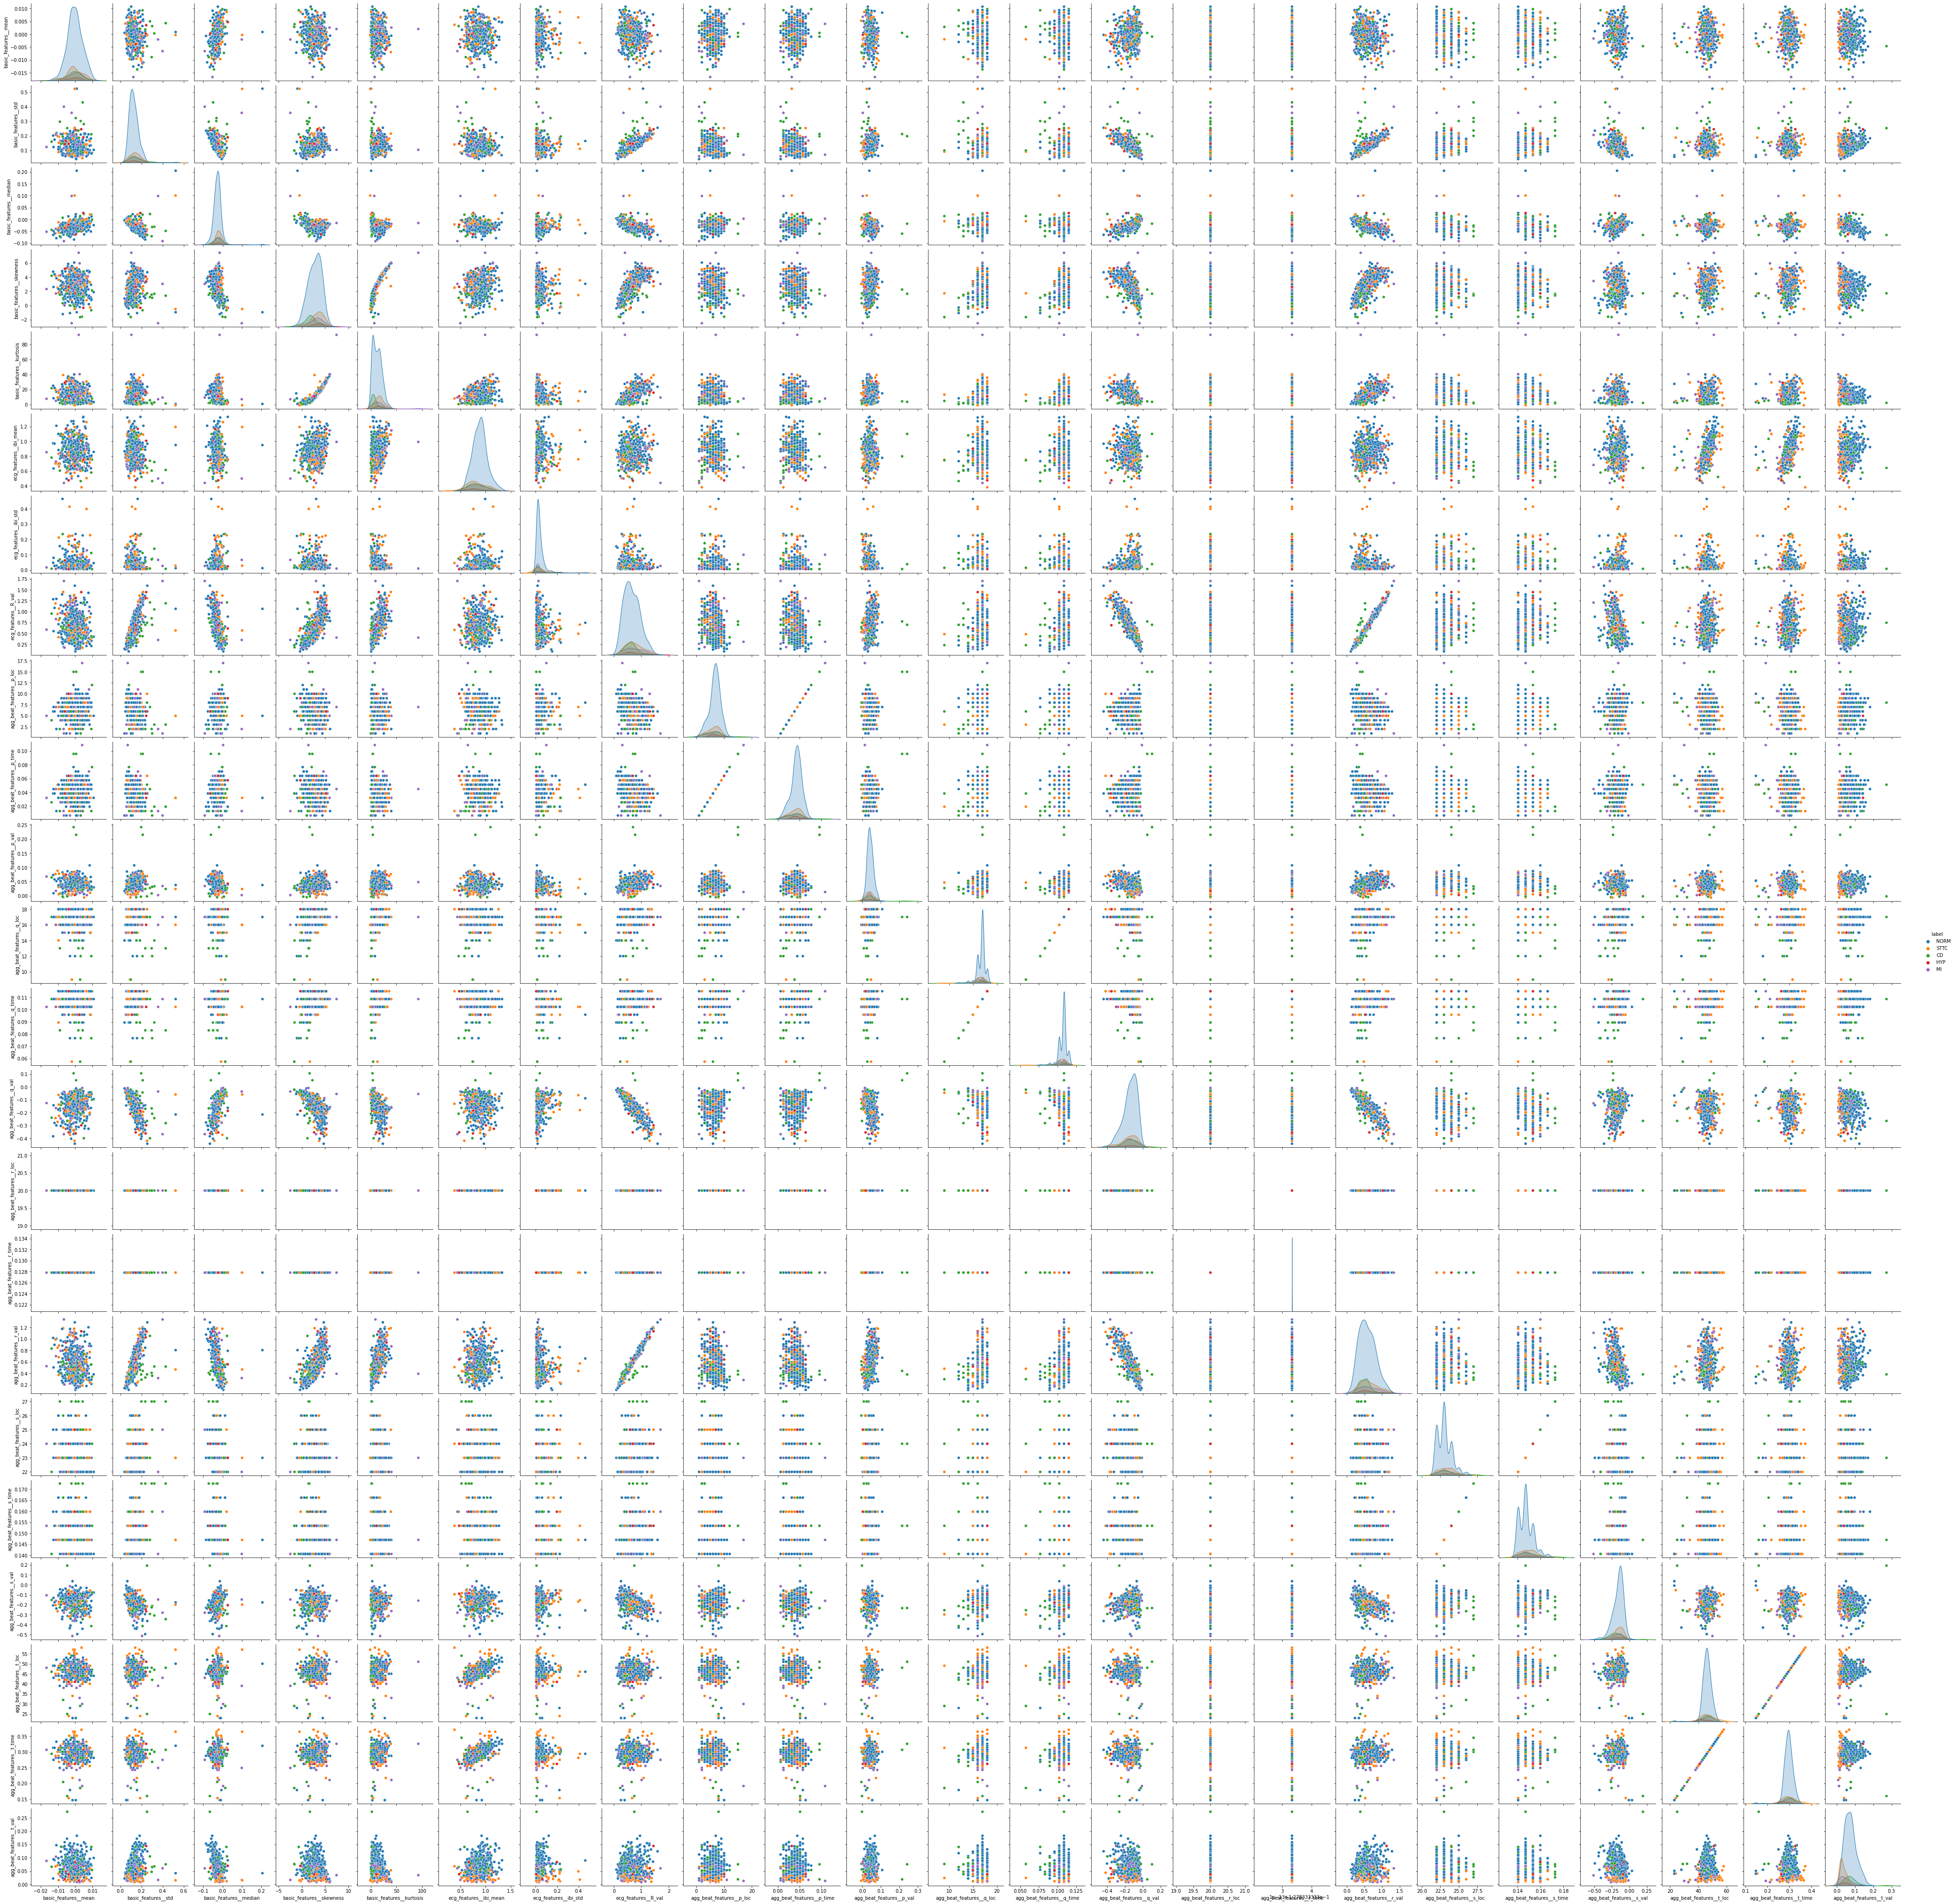

In [117]:
sns.pairplot(df, hue='label')

In [153]:
df['label'] = LabelEncoder().fit_transform(df['label'].values)

In [154]:
corr = pd.DataFrame(abs(np.corrcoef(df, rowvar=False)), columns=df.columns, index=df.columns)

<AxesSubplot:>

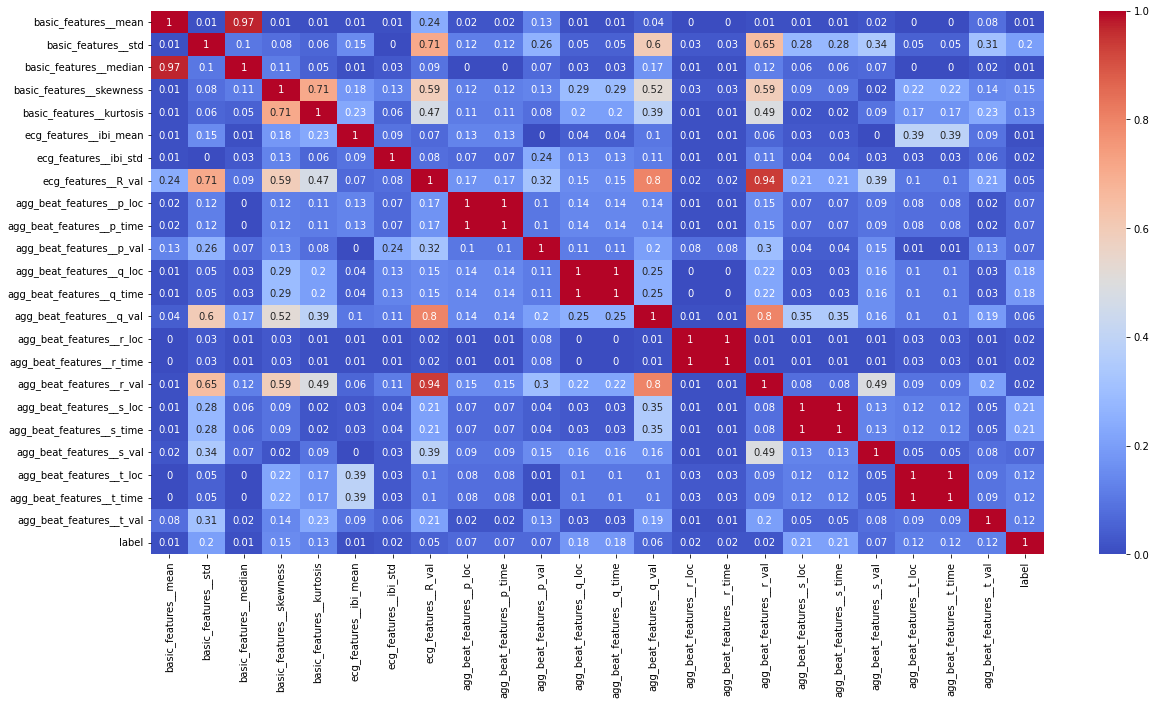

In [155]:
plt.figure(figsize=(20, 10))
sns.heatmap(corr.round(2), cmap='coolwarm', annot=True)

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

model = RandomForestClassifier()
X_train = df.drop('label', axis=1)
y_train = df['label']

X_val = val_df.drop('label', axis=1)
y_val = val_df['label']

X_test = test_df.drop('label', axis=1)
y_test = test_df['label']

model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [189]:
def get_metrics(y_test, model, X):
    y_pred = model.predict(X)
    acc = accuracy_score(y_test, y_pred)
    fscore = f1_score(y_test, y_pred, average='macro')
    auc = roc_auc_score(y_test, model.predict_proba(X), average='macro', multi_class='ovr')
    return {'fscore': fscore, 'acc': acc, 'auc': auc}

train_metrics = get_metrics(y_train, model, X_train)
val_metrics = get_metrics(y_val, model, X_val)
test_metrics = get_metrics(y_test, model, X_test)

# acc = accuracy_score(y_test, y_pred)
# fscore = f1_score(y_test, y_pred, average='macro')
# auc = roc_auc_score(y_test, model.predict_proba(X_test), average='macro', multi_class='ovr')

# print(f"acc: {acc:.2f}")
# print(f"fscore: {fscore:.2f}")
# print(f"auc: {auc:.2f}")

In [192]:
train_metrics, val_metrics, test_metrics

({'fscore': 0.9998849879049689,
  'acc': 0.9999141925519135,
  'auc': 0.9999999766268607},
 {'fscore': 0.603050636662288,
  'acc': 0.7541507024265645,
  'auc': 0.9085852522700204},
 {'fscore': 0.6004993861190439,
  'acc': 0.7580853816300129,
  'auc': 0.8991544111814178})

In [160]:
acc = accuracy_score(y_test, y_pred)
fscore = f1_score(y_test, y_pred, average='macro')
auc = roc_auc_score(y_test, model.predict_proba(X_test), average='macro', multi_class='ovr')

print(f"acc: {acc:.2f}")
print(f"fscore: {fscore:.2f}")
print(f"auc: {auc:.2f}")

acc: 0.63
fscore: 0.50
auc: 0.79


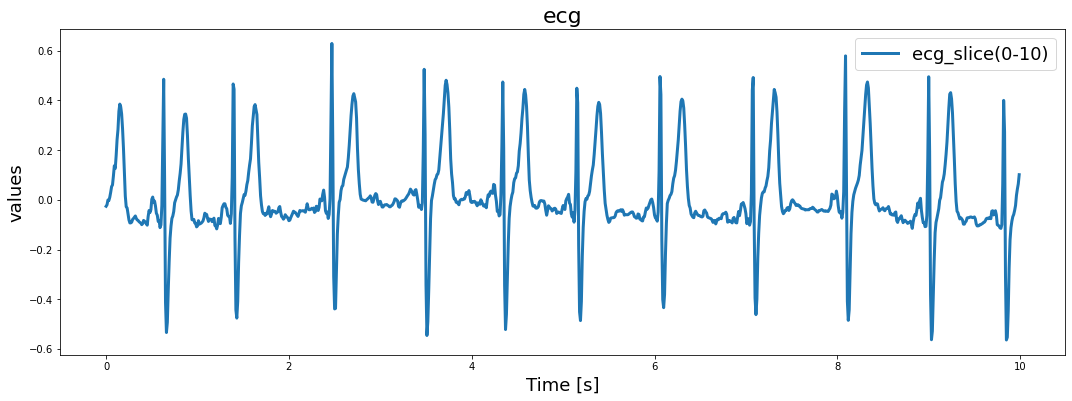

In [92]:
data = ptbxl_data['train']['X'][3333, :, 0]
sig = ECGSignal("ecg", data, 100)
sig.plot()
secg = sig.aggregate()

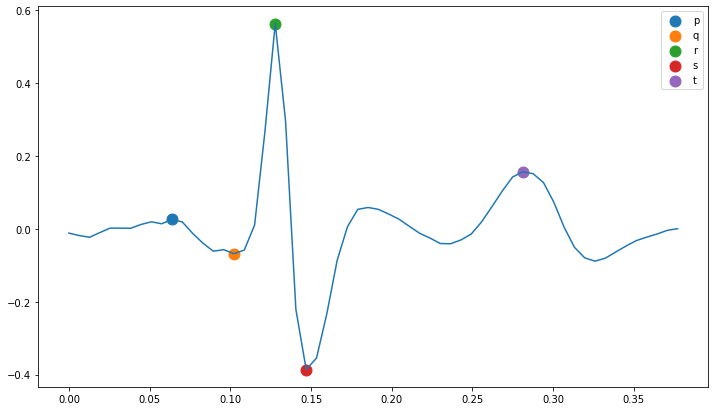

In [95]:
feats = sig.extract_features(plot=False)
feats = parse_nested_feats(feats)